In [17]:
import ROOT
import array as array
from array import array 
import os
import glob
import ROOT
from ROOT import TH1D, TH2D, TTree,TFile, TUnfoldSys, TUnfoldDensity, TUnfold, TDirectoryFile
from random import gauss
import numpy as np
import root_numpy as rtnpy
from root_numpy import *
import h5py
#from awkward import JaggedArray, Table
import matplotlib.pyplot as plt
import seaborn as sns


### Get list of nanoskim files to run over and sum gen event weights (ie, n_events) for a given samples

In [18]:
#%jsroot on

In [19]:
def getListOfFiles(dirName, histos=False):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    #To ensure event counts don't come up against  a histogram file and rather just the nanoskim
    if histos==False: ftype="nanoskim"
    else: ftype="histogram"
    listOfFile[:] = [x for x in listOfFile if "%s"%ftype in x]
    #print (listOfFile)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):            
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

#print (getListOfFiles('/pnfs/psi.ch/cms/trivcat/store/user/kadatta/jetObservables/ZZ_TuneCP5_13TeV-pythia8/jetObservables_Skimmer_UL17_ZZ_v1/201125_043451/0000/'))

In [20]:
dict_MCscaling_UL17 = {
    
    'TTToSemiLeptonic': ["365.34", 32392787477.908009,
                         '../TTToSemileptonic_powheg_pythia8_2017UL.root',
                        ],
    'TTJets': ["722.8", 285095726103.23967,
               '../TTJets_amcatnloFXFX-pythia8_2017UL.root',
              ],
    'TTTo2L2Nu': ["88.29 ", 4759777104.469412, 
                  '../TTTo2L2Nu_powheg_pythia8_2017UL.root',
                 ],
    'WJetsToLNu': ["5.368e+04", 8110137121728.131836, 
                   '../WJetsToLNu_madgraphMLM_pythia8_2017UL.root',
                  ],
    'ST_s-channel': ["3.549e+00", 70439807.475972, 
                     '../ST_s-channel_amcatnlo_pythia8_2017UL.root'
                    ],
    #'ST_t-channel_top': ["1.197e+02", 655197632.514000, 
    #                     '../ST_t-channel_top_powheg_pythia8_2017UL.root'
    #                    ],
    'ST_t-channel_antitop': ["7.174e+01", 265124234.844000, 
                            '../ST_t-channel_antitop_powheg_pythia8_2017UL.root'
                            ],
    'ST_tW_top': ["3.245e+01", 331239851.967700, 
                  '../ST_tW_top_powheg_pythia8_2017UL.root'
                 ],
    'ST_tW_antitop': ["3.251e+01", 303960792.435600, 
                     '../ST_tW_antitop_powheg_pythia8_2017UL.root',
                     ],
    'QCD_Pt_170to300': ["7055.0", 36027673.000000, 
                        '../QCD_Pt_170to300_pythia8_2017UL.root'
                       ],
    'QCD_Pt_300to470': ["619.3", 494796.072880, 
                        '../QCD_Pt_300to470_pythia8_2017UL.root'   
                       ],
    'QCD_Pt_470to600': ["59.24", 517383.713837, 
                        '../QCD_Pt_470to600_pythia8_2017UL.root'
                       ],
    'QCD_Pt_600to800': ["18.21", 17318812.571925, 
                        '../QCD_Pt_600to800_pythia8_2017UL.root'
                       ],
    #'QCD_Pt_800to1000': ["2.597e+01", 39261600.000000, 
    #                     '../QCD_Pt_800to1000_pythia8_2017UL.root'    
    #                    ],
    'QCD_Pt_1000toInf': ["1.078", 14642553.000000, 
                          '../QCD_Pt_1000to1400_pythia8_2017UL.root'
                         ],
    
    #'WW': ["7.577e+01", 7876265.259367, 
    #      '../WW_pythia8_2017UL.root'  
    #      ],
    #'WZ': ["1.21e+00", 3970000.000000, 
    #       '../WZ_pythia8_2017UL.root'    
    #      ],
    #'ZZ': ["2.748e+00", 1981800.000000, 
    #       '../ZZ_pythia8_2017UL.root'
    #      ]
    }


In [21]:
lumi=4653.71+9289.53+11758.83
print (lumi)

samples = list(dict_MCscaling_UL17.keys())
dict_items = list(dict_MCscaling_UL17.items())
xsecs = np.array(list(float(dict_items[k][1][0]) for k in np.arange(0,len(dict_items)))) 
nevts = np.array(list(float(dict_items[k][1][1]) for k in np.arange(0,len(dict_items)))) 
fpathsMC = np.array(list((dict_items[k][1][2]) for k in np.arange(0,len(dict_items))))
fpathData = '../SingleMuonAll_2017UL.root'
print (xsecs, samples, nevts, fpathsMC)

25702.07
[3.6534e+02 7.2280e+02 8.8290e+01 5.3680e+04 3.5490e+00 7.1740e+01
 3.2450e+01 3.2510e+01 7.0550e+03 6.1930e+02 5.9240e+01 1.8210e+01
 1.0780e+00] ['TTToSemiLeptonic', 'TTJets', 'TTTo2L2Nu', 'WJetsToLNu', 'ST_s-channel', 'ST_t-channel_antitop', 'ST_tW_top', 'ST_tW_antitop', 'QCD_Pt_170to300', 'QCD_Pt_300to470', 'QCD_Pt_470to600', 'QCD_Pt_600to800', 'QCD_Pt_1000toInf'] [3.23927875e+10 2.85095726e+11 4.75977710e+09 8.11013712e+12
 7.04398075e+07 2.65124235e+08 3.31239852e+08 3.03960792e+08
 3.60276730e+07 4.94796073e+05 5.17383714e+05 1.73188126e+07
 1.46425530e+07] ['../TTToSemileptonic_powheg_pythia8_2017UL.root'
 '../TTJets_amcatnloFXFX-pythia8_2017UL.root'
 '../TTTo2L2Nu_powheg_pythia8_2017UL.root'
 '../WJetsToLNu_madgraphMLM_pythia8_2017UL.root'
 '../ST_s-channel_amcatnlo_pythia8_2017UL.root'
 '../ST_t-channel_antitop_powheg_pythia8_2017UL.root'
 '../ST_tW_top_powheg_pythia8_2017UL.root'
 '../ST_tW_antitop_powheg_pythia8_2017UL.root'
 '../QCD_Pt_170to300_pythia8_2017UL.root

In [22]:
def Fill1D(h0,h,bins):
    N=h0.GetNbinsX()
    content=np.zeros((len(bins)-1),dtype=float)
    errors=np.zeros((len(bins)-1),dtype=float)

    for i in range(len(bins)-1):
        content[i]=0
    for i in range(N):
        center=h0.GetBinCenter(i+1)
        index=np.digitize(np.array([center]),bins)
        if index[0] < len(bins):
            content[index[0]-1]+=h0.GetBinContent(i+1)
            errors[index[0]-1]+=h0.GetBinError(i+1)
    for i in range(len(bins)-1):
        h.SetBinContent(i+1,content[i])
        h.SetBinError(i+1,errors[i])

def Fill2D(h0,h,binx,biny):
    Nx=h0.GetNbinsX()
    Ny=h0.GetNbinsY()
    hx=h0.ProjectionX()
    hy=h0.ProjectionY()
    content=np.zeros((len(binx)-1,len(biny)-1),dtype=float)
    errors=np.zeros((len(binx)-1,len(biny)-1),dtype=float)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            content[i][j]=0
    for i in range(Nx):
        for j in range(Ny):
            centerx=hx.GetBinCenter(i+1)
            indexx=np.digitize(np.array([centerx]),binx)
            centery=hy.GetBinCenter(j+1)
            indexy=np.digitize(np.array([centery]),biny)
            if indexx[0] < len(binx) and indexy[0] < len(biny):
                content[indexx[0]-1][indexy[0]-1]+=h0.GetBinContent(i+1,j+1)
                errors[indexx[0]-1][indexy[0]-1]+=ROOT.TMath.Power(h0.GetBinError(i+1,j+1),2)
                
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            h.SetBinContent(i+1,j+1,content[i][j])
            h.SetBinError(i+1,j+1,ROOT.TMath.Sqrt(errors[i][j]))


In [23]:
def DoUnfolding(Response,Reco):
    tunfolder = ROOT.TUnfoldDensity(Response,ROOT.TUnfold.kHistMapOutputHoriz,ROOT.TUnfold.kRegModeCurvature, ROOT.TUnfold.kEConstraintNone, ROOT.TUnfoldDensity.kDensityModeBinWidth)
    tunfolder.SetInput(Reco)
    tunfolder.DoUnfold(0.)
    return tunfolder.GetOutput("MC_unfolded")
def CrossClosure(response1,reco1,response2,reco2):
    unf11=DoUnfolding(response1,reco1)
    unf12=DoUnfolding(response2,reco1)
    unf21=DoUnfolding(response1,reco2)
    unf22=DoUnfolding(response2,reco2)
    return unf11,unf12,unf21,unf22
def SelfClosure(response1,reco2,response2,reco1):
    unf21=DoUnfolding(response1,reco2)
    unf12=DoUnfolding(response2,reco1)
    return unf21,unf12

In [24]:
def getRebinnedRescaledHist(hist_name, file_name, xrange, scale, isMC=True):
    #if not(sample_name in file_name): 
    #    return "File either not available or needs to be renamed to be compatible with this (poorly,) hard-coded piece of software..."
    
    FILE = ROOT.TFile.Open(file_name,'read')
    tree = FILE.Get('jetObservables')
    hist = tree.Get(hist_name)
    hist.SetDirectory(0)
    
    ROOT.TH1.AddDirectory(ROOT.kFALSE);
    
    bins = array('d', np.array(Bin(xrange)))
    
    newHist = ROOT.TH1F(hist.Rebin(len(bins)-1, "%s_rebin"%hist_name, bins))
    #newHist.SetStats(ROOT.kFALSE)
    if isMC==True: newHist.Scale(scale)
    
    return newHist

In [25]:
from array import array
ROOT.gStyle.SetOptStat(0)

In [26]:
varNames_topSel=np.array([
    'tau_0p5_1', 'tau_1_1', 'tau_2_1', 
    'tau_0p5_2', 'tau_1_2', 'tau_2_2',
    'tau_0p5_3', 'tau_1_3', 'tau_2_3',
    'tau_0p5_4', 'tau_1_4', 'tau_2_4',
    'tau21', 'tau32'
    ])
recoHist_topSel=np.array([
    'recoJet_tau_0p5_1_nom_topSel', 'recoJet_tau_1_1_nom_topSel', 'recoJet_tau_2_1_nom_topSel',
    'recoJet_tau_0p5_2_nom_topSel', 'recoJet_tau_1_2_nom_topSel', 'recoJet_tau_2_2_nom_topSel',
    'recoJet_tau_0p5_3_nom_topSel', 'recoJet_tau_1_3_nom_topSel', 'recoJet_tau_2_3_nom_topSel',
    'recoJet_tau_0p5_4_nom_topSel', 'recoJet_tau_1_4_nom_topSel', 'recoJet_tau_2_4_nom_topSel',
    'recoJet_tau21_nom_topSel', 'recoJet_tau32_nom_topSel'
    ])
fakerecoHist_topSel=np.array([
    'fakerecoJet_tau_0p5_1_nom_topSel', 'fakerecoJet_tau_1_1_nom_topSel', 'fakerecoJet_tau_2_1_nom_topSel',
    'fakerecoJet_tau_0p5_2_nom_topSel', 'fakerecoJet_tau_1_2_nom_topSel', 'fakerecoJet_tau_2_2_nom_topSel',
    'fakerecoJet_tau_0p5_3_nom_topSel', 'fakerecoJet_tau_1_3_nom_topSel', 'fakerecoJet_tau_2_3_nom_topSel',
    'fakerecoJet_tau_0p5_4_nom_topSel', 'fakerecoJet_tau_1_4_nom_topSel', 'fakerecoJet_tau_2_4_nom_topSel',
    'fakerecoJet_tau21_nom_topSel', 'fakerecoJet_tau32_nom_topSel',
    ])
truerecoHist_topSel=np.array([
    'truerecoJet_tau_0p5_1_nom_topSel', 'truerecoJet_tau_1_1_nom_topSel', 'truerecoJet_tau_2_1_nom_topSel',
    'truerecoJet_tau_0p5_2_nom_topSel', 'truerecoJet_tau_1_2_nom_topSel', 'truerecoJet_tau_2_2_nom_topSel',
    'truerecoJet_tau_0p5_3_nom_topSel', 'truerecoJet_tau_1_3_nom_topSel', 'truerecoJet_tau_2_3_nom_topSel',
    'truerecoJet_tau_0p5_4_nom_topSel', 'truerecoJet_tau_1_4_nom_topSel', 'truerecoJet_tau_2_4_nom_topSel',
    'truerecoJet_tau21_nom_topSel', 'truerecoJet_tau32_nom_topSel',
    ])
genHist_topSel=np.array([
    'genJet_tau_0p5_1_topSel', 'genJet_tau_1_1_topSel', 'genJet_tau_2_1_topSel',
    'genJet_tau_0p5_2_topSel', 'genJet_tau_1_2_topSel', 'genJet_tau_2_2_topSel',
    'genJet_tau_0p5_3_topSel', 'genJet_tau_1_3_topSel', 'genJet_tau_2_3_topSel',
    'genJet_tau_0p5_4_topSel', 'genJet_tau_1_4_topSel', 'genJet_tau_2_4_topSel',
    'genJet_tau21_topSel', 'genJet_tau32_topSel',
    ])
accepgenHist_topSel=np.array([
    'accepgenJet_tau_0p5_1_topSel', 'accepgenJet_tau_1_1_topSel', 'accepgenJet_tau_2_1_topSel',
    'accepgenJet_tau_0p5_2_topSel', 'accepgenJet_tau_1_2_topSel', 'accepgenJet_tau_2_2_topSel',
    'accepgenJet_tau_0p5_3_topSel', 'accepgenJet_tau_1_3_topSel', 'accepgenJet_tau_2_3_topSel',
    'accepgenJet_tau_0p5_4_topSel', 'accepgenJet_tau_1_4_topSel', 'accepgenJet_tau_2_4_topSel',
    'accepgenJet_tau21_topSel', 'accepgenJet_tau32_topSel',
    ])
missgenHist_topSel=np.array([
    'missgenJet_tau_0p5_1_topSel', 'missgenJet_tau_1_1_topSel', 'missgenJet_tau_2_1_topSel',
    'missgenJet_tau_0p5_2_topSel', 'missgenJet_tau_1_2_topSel', 'missgenJet_tau_2_2_topSel',
    'missgenJet_tau_0p5_3_topSel', 'missgenJet_tau_1_3_topSel', 'missgenJet_tau_2_3_topSel',
    'missgenJet_tau_0p5_4_topSel', 'missgenJet_tau_1_4_topSel', 'missgenJet_tau_2_4_topSel',
    'missgenJet_tau21_topSel', 'missgenJet_tau32_topSel',
    ])

response_topSel=np.array([
    'respJet_tau_0p5_1_nom_topSel', 'respJet_tau_1_1_nom_topSel', 'respJet_tau_2_1_nom_topSel',
    'respJet_tau_0p5_2_nom_topSel', 'respJet_tau_1_2_nom_topSel', 'respJet_tau_2_2_nom_topSel',
    'respJet_tau_0p5_3_nom_topSel', 'respJet_tau_1_3_nom_topSel', 'respJet_tau_2_3_nom_topSel',
    'respJet_tau_0p5_4_nom_topSel', 'respJet_tau_1_4_nom_topSel', 'respJet_tau_2_4_nom_topSel',
    'respJet_tau21_nom_topSel', 'respJet_tau32_nom_topSel',
    ])
HistLabels_topSel=np.array([
    ['Events/0.03','#tau_{1}^{(0.5)}','#tau_{1}^{(0.5)}'],['Events/0.02','#tau_{1}^{(1)}','#tau_{1}^{(1)}'],['Events/0.02','#tau_{1}^{(2)}','#tau_{1}^{(2)}'],
    ['Events/0.03','#tau_{2}^{(0.5)}','#tau_{2}^{(0.5)}'],['Events/0.02','#tau_{2}^{(1)}','#tau_{2}^{(1)}'],['Events/0.01','#tau_{2}^{(2)}','#tau_{2}^{(2)}'],
    ['Events/0.02','#tau_{3}^{(0.5)}','#tau_{3}^{(0.5)}'],['Events/0.02','#tau_{3}^{(1)}','#tau_{3}^{(1)}'],['Events/0.01','#tau_{3}^{(2)}','#tau_{3}^{(2)}'],
    ['Events/0.02','#tau_{4}^{(0.5)}','#tau_{4}^{(0.5)}'],['Events/0.01','#tau_{4}^{(1)}','#tau_{4}^{(1)}'],['Events/0.01','#tau_{4}^{(2)}','#tau_{4}^{(2)}'],
    ['Events/0.01','#tau_{2,1}^{(1)}','#tau_{2,1}^{(1)}'],['Events/0.01','#tau_{3,2}^{(1)}','#tau_{3,2}^{(1)}']
    ])
genBin_topSel=[
    array('d',[0., 0.2, 0.26, 0.32, 0.38, 0.44,  0.5, 0.56, 0.62, 0.68, 0.74, 0.8, 0.9]),
    array('d',[0., 0.1, 0.14, 0.18, 0.22, 0.26, 0.30, 0.34, 0.38, 0.42, 0.46, 0.5, 0.54, 0.64]), 
    array('d',[0., 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.42, 0.48]),
    array('d',[0., 0.1, 0.16, 0.22, 0.28, 0.34, 0.4, 0.46, 0.52, 0.58, 0.64, 0.7, 0.8]),
    array('d',[0., 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.42]), 
    array('d',[0., 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.16, 0.2]), 
    array('d',[0.0, 0.1, 0.14, 0.18, 0.22, 0.26, 0.3, 0.34, 0.38, 0.44, 0.5, 0.6]), 
    array('d',[0., 0.02, 0.04, 0.06, 0.08, 0.11, 0.14, 0.17, 0.2, 0.24, 0.28]), 
    array('d',[0., 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,0.1]), 
    array('d',[0.0, 0.1, 0.14, 0.18, 0.22, 0.26, 0.3, 0.34, 0.4, 0.46]), 
    array('d',[0., 0.02, 0.04, 0.06, 0.08, 0.1, 0.13, 0.16, 0.19, 0.22, 0.26]), 
    array('d',[0., 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]),
    array('d',[0., 0.1, 0.18, 0.26, 0.34, 0.42, 0.5, 0.58, 0.66, 0.74, 0.82, 0.9, 1.]),
    array('d',[0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
    ]
recoBin_topSel = np.copy(genBin_topSel)

for i in range(len(genBin_topSel)):
    gen_bin = genBin_topSel[i]
    reco_bin = array('d', np.sort(np.append(gen_bin, np.array([np.round((gen_bin[j]+gen_bin[j+1])/2,3) for j in range(len(gen_bin)-1)]))))
    #print (len(gen_bin), gen_bin, "\n", len(reco_bin), reco_bin)
    recoBin_topSel[i] = reco_bin
    
for i in range(len(genBin_topSel)):
    print (varNames_topSel[i], genBin_topSel[i], recoBin_topSel[i])


tau_0p5_1 array('d', [0.0, 0.2, 0.26, 0.32, 0.38, 0.44, 0.5, 0.56, 0.62, 0.68, 0.74, 0.8, 0.9]) array('d', [0.0, 0.1, 0.2, 0.23, 0.26, 0.29, 0.32, 0.35, 0.38, 0.41, 0.44, 0.47, 0.5, 0.53, 0.56, 0.59, 0.62, 0.65, 0.68, 0.71, 0.74, 0.77, 0.8, 0.85, 0.9])
tau_1_1 array('d', [0.0, 0.1, 0.14, 0.18, 0.22, 0.26, 0.3, 0.34, 0.38, 0.42, 0.46, 0.5, 0.54, 0.64]) array('d', [0.0, 0.05, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.59, 0.64])
tau_2_1 array('d', [0.0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.42, 0.48]) array('d', [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.39, 0.42, 0.45, 0.48])
tau_0p5_2 array('d', [0.0, 0.1, 0.16, 0.22, 0.28, 0.34, 0.4, 0.46, 0.52, 0.58, 0.64, 0.7, 0.8]) array('d', [0.0, 0.05, 0.1, 0.13, 0.16, 0.19, 0.22, 0.25, 0.28, 0.31, 0.34, 0.37, 0.4, 0.43, 0.46, 0.49, 0.52, 0.55, 0.58, 0.61, 0.64, 0.67, 0.

# All $\tau_N$ self closure 80:20 split Powheg+Pythia8 (nominal)

In [27]:
def Scale(h):
    n=h.Integral()
    h.Scale(1./n,"width")

In [28]:
scale1=lumi*xsecs[0]/24408467409.656002 #big split
scale2=lumi*xsecs[0]/7984320068.252007 #small split

In [29]:
fData=[]
path='../SingleMuonAll_2017UL.root'
files=glob.glob(path)
for f in files:
    fData.append(f)
print (len(fData))

fMC=[
    '../TTSemileptonic_bigSplit.root',
    '../TTSemileptonic_smallSplit.root'
]
print (len(fMC))

1
2


In [30]:
print (scale1,scale2)

0.0003847023287535584 0.0011760543381943522


tau_0p5_1 array('d', [0.0, 0.2, 0.26, 0.32, 0.38, 0.44, 0.5, 0.56, 0.62, 0.68, 0.74, 0.8, 0.9]) array('d', [0.0, 0.1, 0.2, 0.23, 0.26, 0.29, 0.32, 0.35, 0.38, 0.41, 0.44, 0.47, 0.5, 0.53, 0.56, 0.59, 0.62, 0.65, 0.68, 0.71, 0.74, 0.77, 0.8, 0.85, 0.9])
loading files
Re-filling histos
Unfolding and scaling histos
tau_1_1 array('d', [0.0, 0.1, 0.14, 0.18, 0.22, 0.26, 0.3, 0.34, 0.38, 0.42, 0.46, 0.5, 0.54, 0.64]) array('d', [0.0, 0.05, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.59, 0.64])
loading files
Re-filling histos
Unfolding and scaling histos
tau_2_1 array('d', [0.0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.42, 0.48]) array('d', [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.39, 0.42, 0.45, 0.48])
loading files
Re-filling histos
Unfolding and scaling histos
tau_0p5_2 array('d', [0.0, 0.1, 0.16, 0.22, 0.28, 0.34, 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco Powheg+P8_75pc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen Powheg+P8_75pc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response matrix Powheg+P8_75pc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco Powheg+P8_25pc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen Powheg+P8_25pc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response matrix Powheg+P8_25pc (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Warning in <TUnfold::TUnfold>: 4 output bins do not depend on the input data  0-1 12-13
Info in <TUnfold::TUnfold>: 24 input bins and 10 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{1}^{(0.5)} gen[ufl])
Info in <TUnfoldDensity::TU

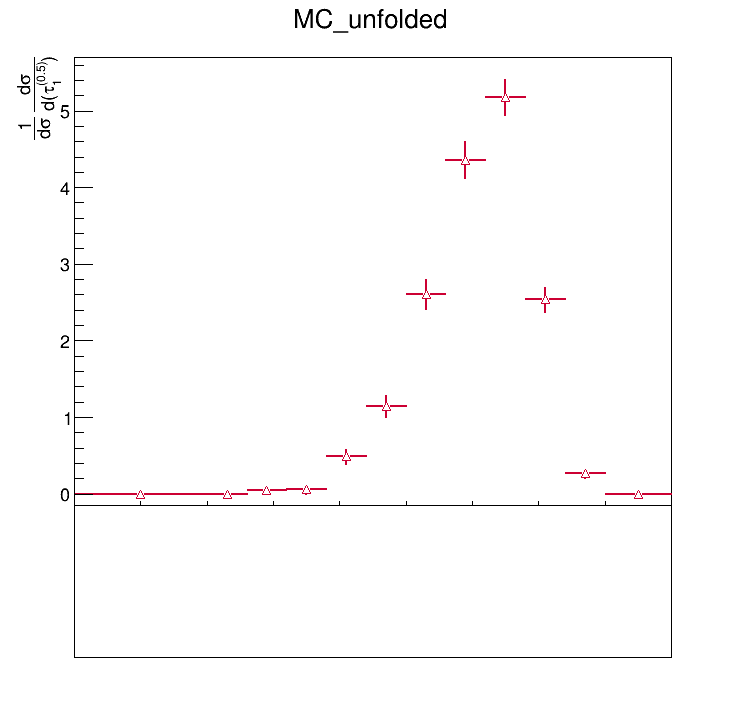

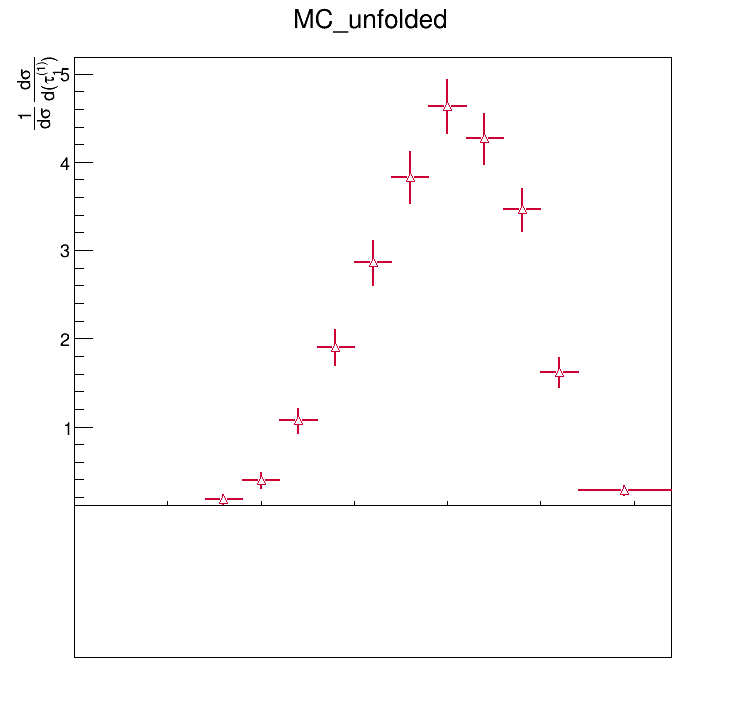

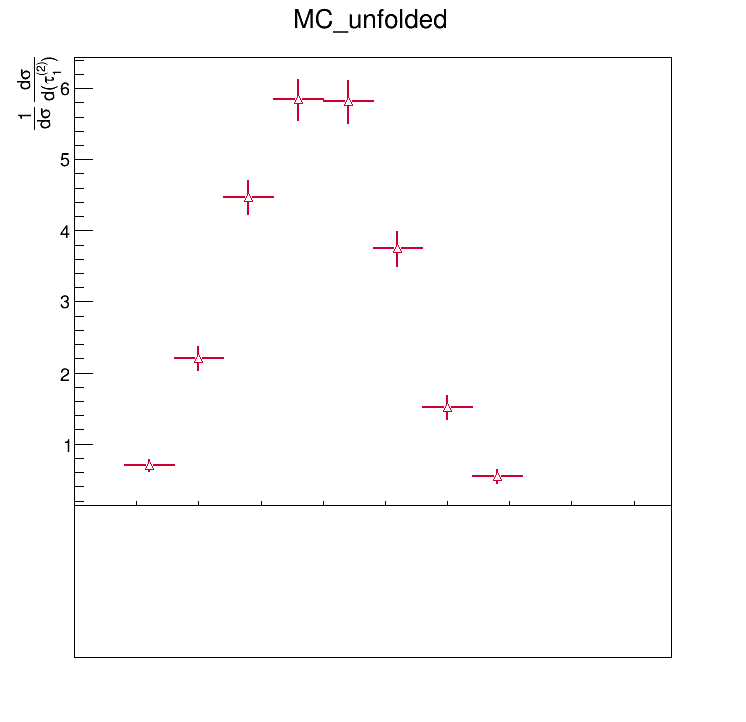

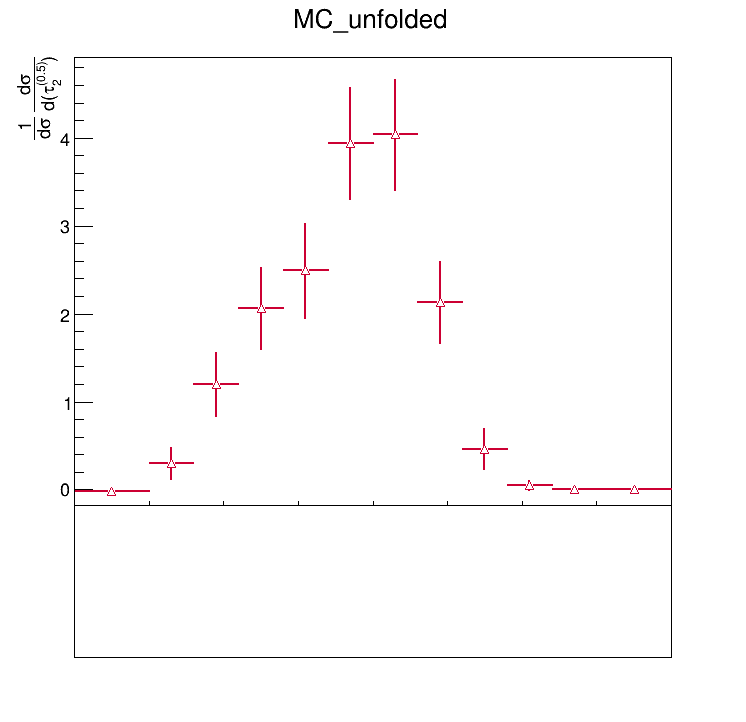

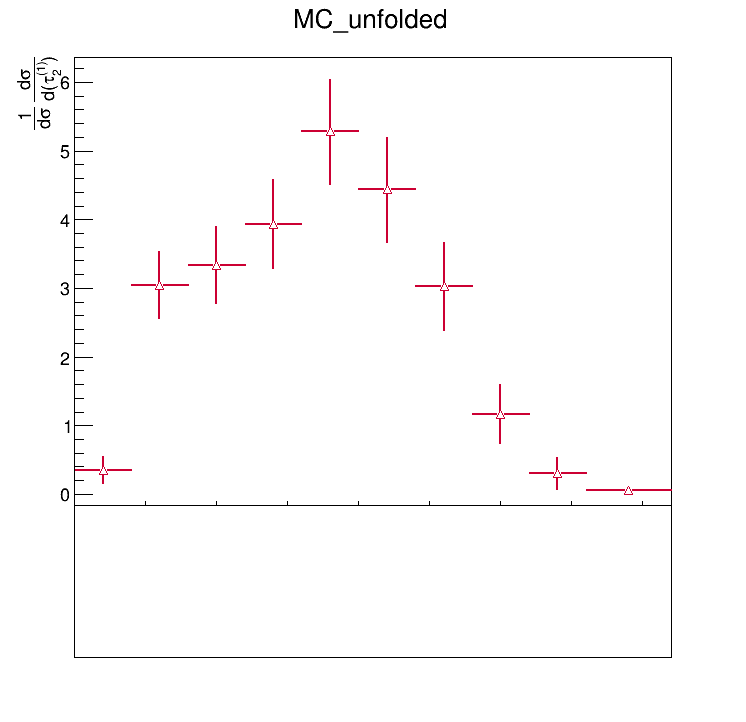

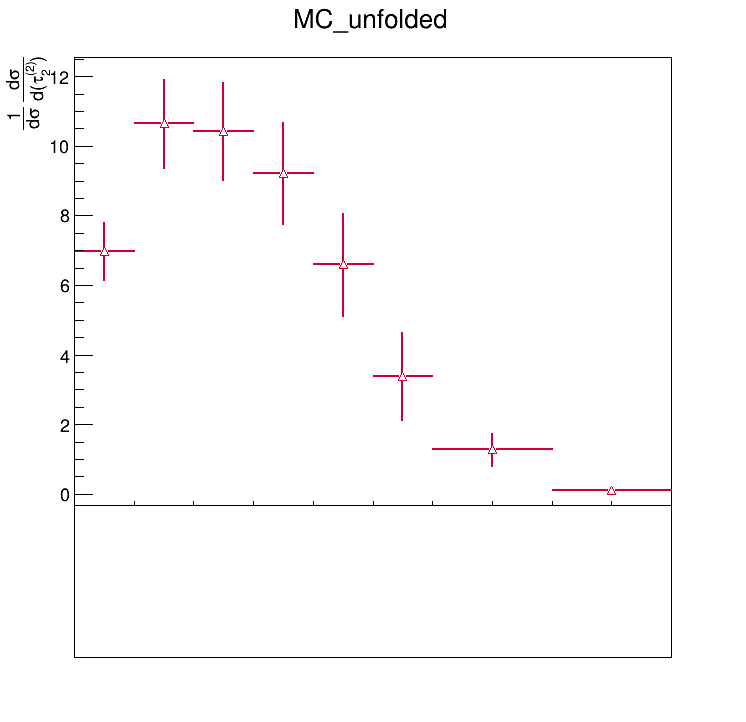

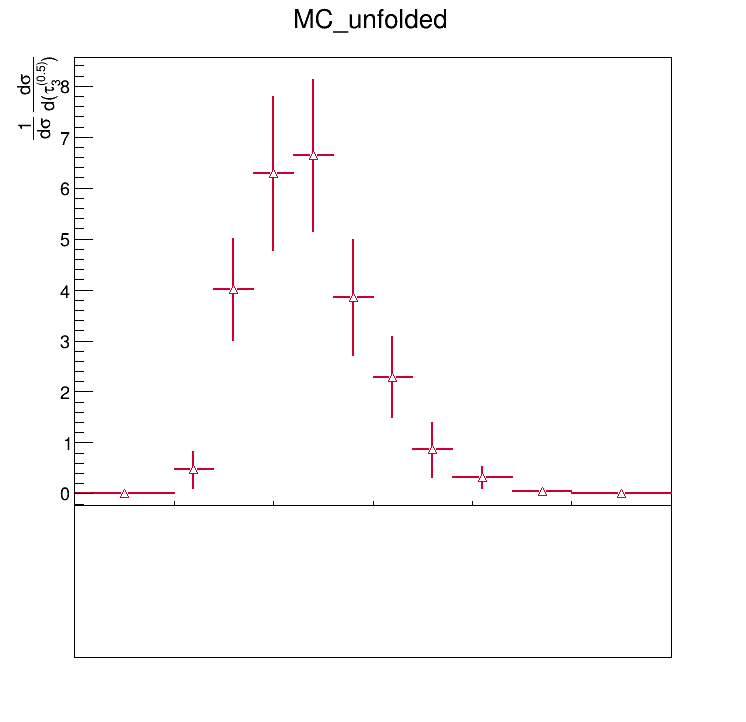

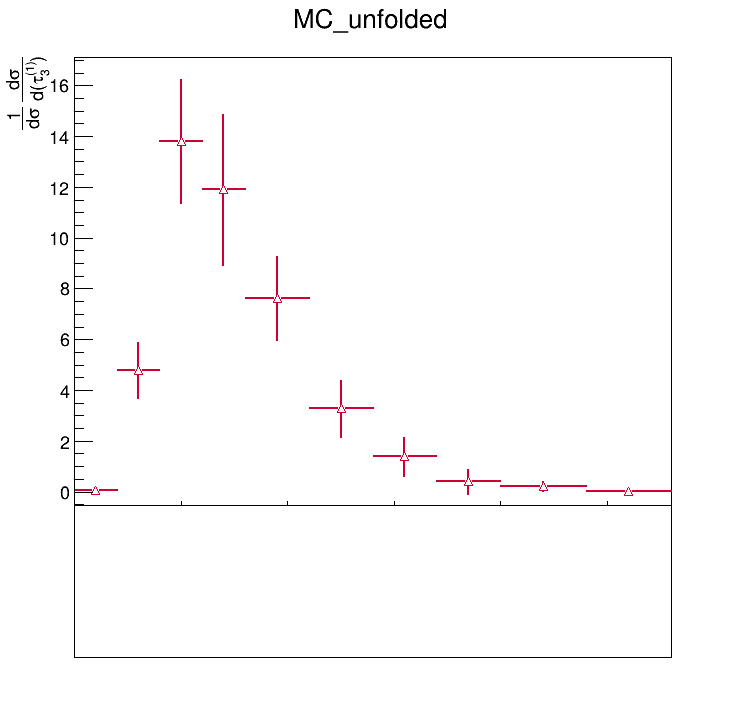

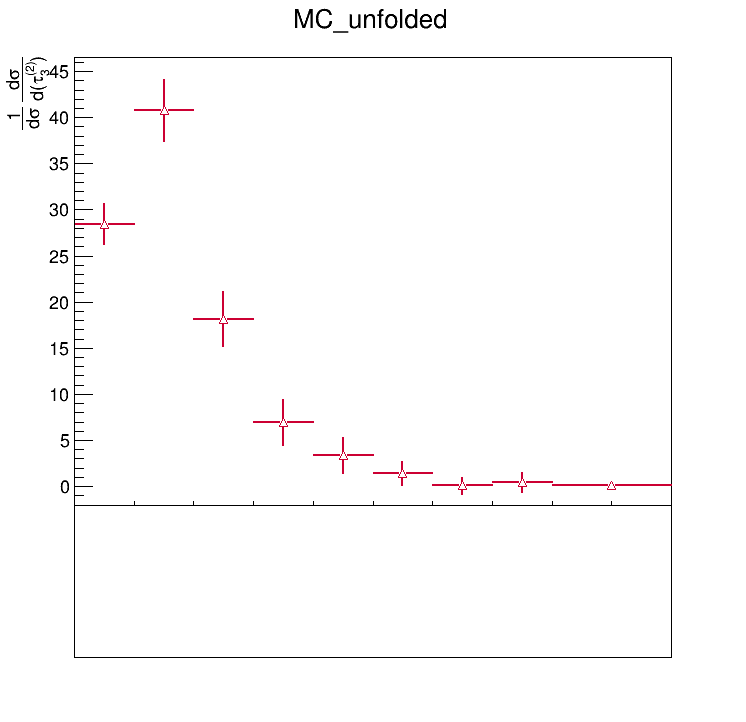

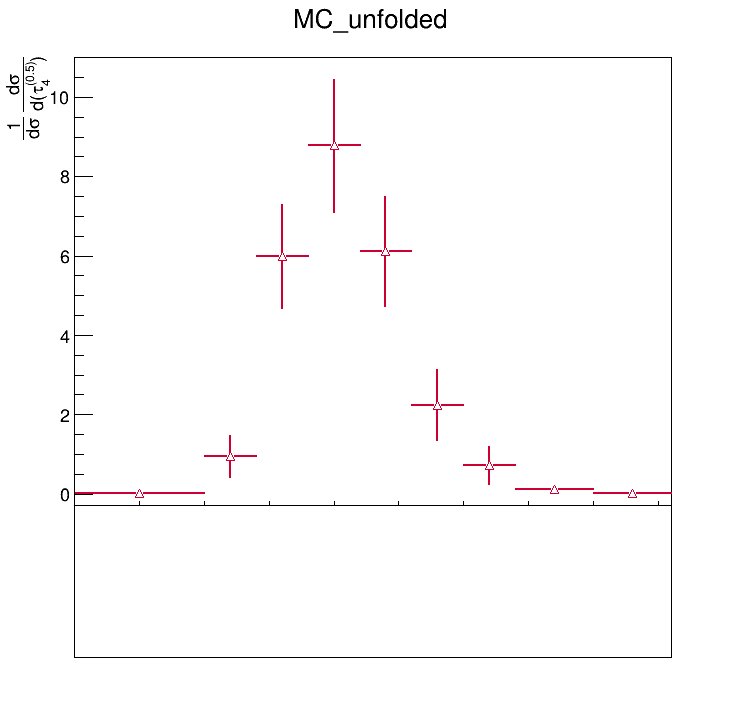

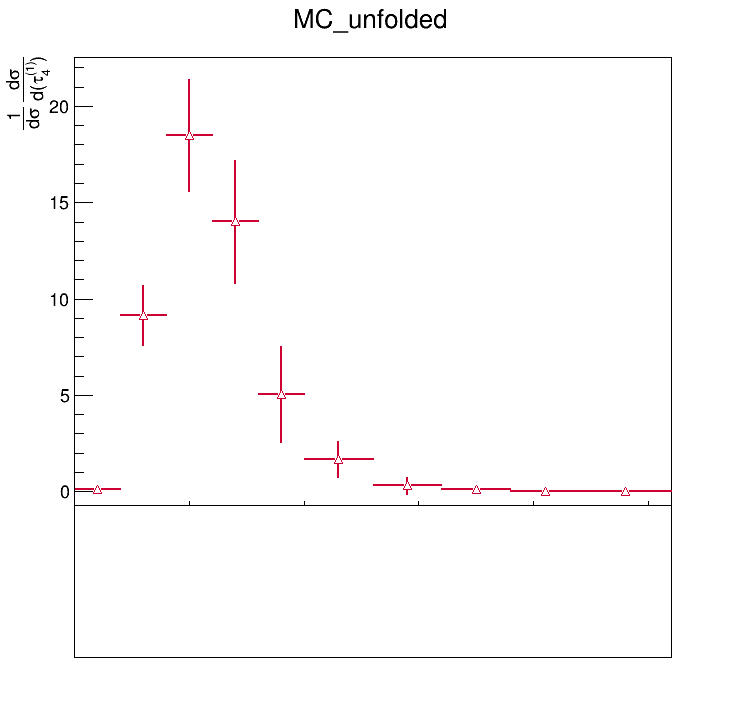

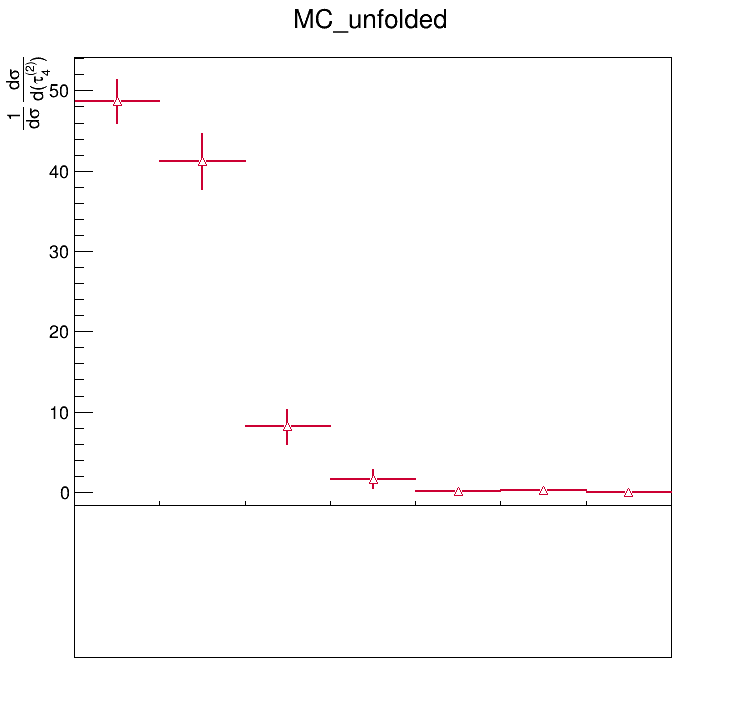

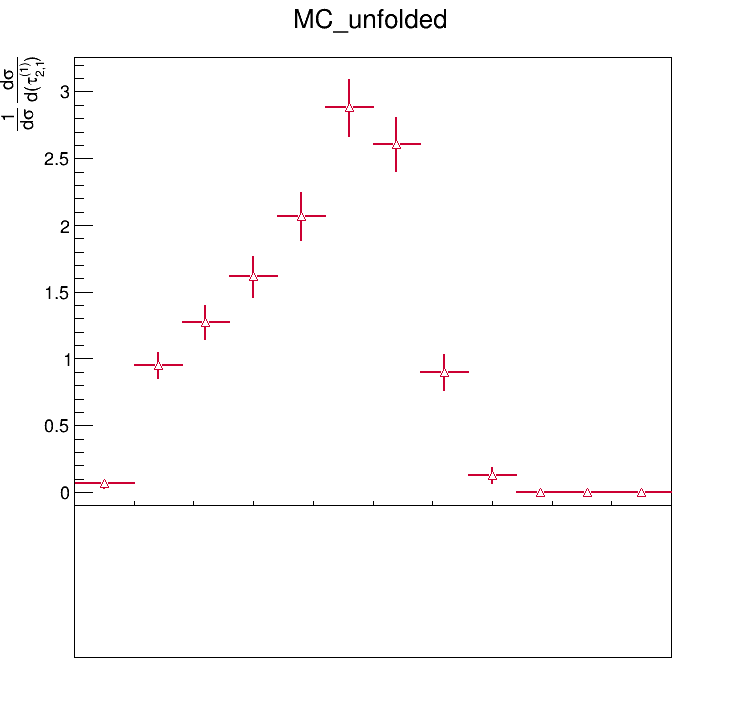

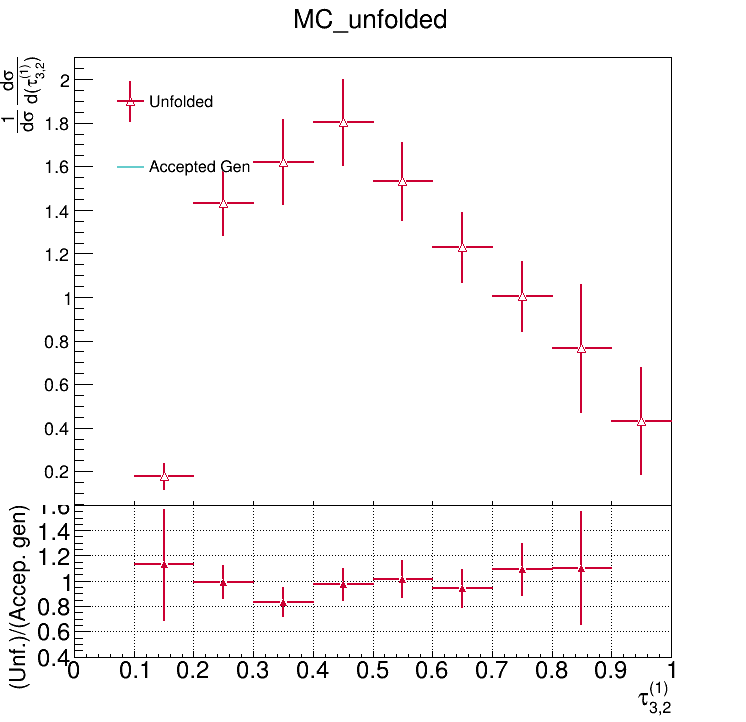

In [32]:
canvases2 = []
for i in range(len(genBin_topSel)):
    c = ROOT.TCanvas("c%d"%i,"c%d"%i,10, 10, 750, 750 )
    canvases2.append(c)
    

for i in range(len(canvases2)):
    
    
    print (varNames_topSel[i], genBin_topSel[i], recoBin_topSel[i])
    gen_bin = genBin_topSel[i]
    reco_bin = recoBin_topSel[i]
    
    can=canvases2[i]
    
    MC1_reco=ROOT.TH1D("MC_reco Powheg+P8_75pc","MC_reco Powheg+P8_75pc;#tau_{1}^{(0.5)};Events/0.01",len(reco_bin)-1,reco_bin)
    MC1_gen=ROOT.TH1D("MC_gen Powheg+P8_75pc","MC_gen Powheg+P8_75pc;#tau_{1}^{(0.5)};Events/0.01",len(gen_bin)-1,gen_bin)
    Response1=ROOT.TH2D("Response matrix Powheg+P8_75pc","Response matrix Powheg+P8_75pc;#tau_{1}^{(0.5)} gen;#tau_{1}^{(0.5)} reco",len(gen_bin)-1,gen_bin,len(reco_bin)-1,reco_bin)
    MC2_reco=ROOT.TH1D("MC_reco Powheg+P8_25pc","MC_reco Powheg+P8_25pc;#tau_{1}^{(0.5)};Events/0.01",len(reco_bin)-1,reco_bin)
    MC2_gen=ROOT.TH1D("MC_gen Powheg+P8_25pc","MC_gen Powheg+P8_25pc;#tau_{1}^{(0.5)};Events/0.01",len(gen_bin)-1,gen_bin)
    Response2=ROOT.TH2D("Response matrix Powheg+P8_25pc","Response matrix Powheg+P8_25pc;#tau_{1}^{(0.5)} gen;#tau_{1}^{(0.5)} reco",len(gen_bin)-1,gen_bin,len(reco_bin)-1,reco_bin)
    
    print ("loading files")
    file_MC=np.zeros((len(fMC),),dtype=ROOT.TFile)
    file_MC[0]=ROOT.TFile.Open(fMC[0],'read')
    t=file_MC[0].Get('jetObservables')
    MC1_reco0 = t.Get(recoHist_topSel[i])
    #print (MC1_reco0.GetNbinsX())
    MC1_reco0.Scale(scale1)
    MC1_reco0.SetDirectory(0)
    MC1_gen0 = t.Get(accepgenHist_topSel[i])
    MC1_gen0.Scale(scale1)
    MC1_gen0.SetDirectory(0)
    Response1_0 = t.Get(response_topSel[i])
    Response1_0.Scale(scale1)
    Response1_0.SetDirectory(0)
    file_MC[0].Close()
    

    file_MC[1]=ROOT.TFile.Open(fMC[1],'read')
    t=file_MC[1].Get('jetObservables')
    MC2_reco0 = t.Get(recoHist_topSel[i])
    MC2_reco0.Scale(scale2)
    MC2_reco0.SetDirectory(0)
    MC2_gen0  = t.Get(accepgenHist_topSel[i])
    MC2_gen0.Scale(scale2)
    MC2_gen0.SetDirectory(0)
    Response2_0 = t.Get(response_topSel[i])
    Response2_0.Scale(scale2)
    Response2_0.SetDirectory(0)
    file_MC[1].Close()   
    
    
    
    print ("Re-filling histos")
    #print ("Filling resp")
    Fill1D(MC1_reco0,MC1_reco,reco_bin)
    Fill1D(MC1_gen0,MC1_gen,gen_bin)
    Fill2D(Response1_0,Response1,gen_bin,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)    #print ("Filling MC2 reco")
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    #print ("Filling MC2 gen")
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    
    can.cd()
    pad1 = ROOT.TPad("pad1", "Main",0,0.207,1.00,1.00,-1)
    pad2 = ROOT.TPad("pad2", "Ratio",0,0.00,1.00,0.30,-1)
    pad1.Draw()
    pad2.Draw()

    pad1.cd()
    
    if not(varNames_topSel[i] in ["tau_0p5_1", "tau_1_1", "tau32"]): legend1=ROOT.TLegend(0.65,0.65,0.90,0.88)
    else: legend1=ROOT.TLegend(0.15,0.65,0.35,0.88)
    
    legend1.SetFillStyle(0)
    legend1.SetBorderSize(0)

    print ("Unfolding and scaling histos")
    
    unf21,unf12=SelfClosure(Response1,MC2_reco,Response2,MC1_reco)
    #Scale(MC1_gen)
    Scale(unf21)
    Scale(MC2_gen)
    #Scale(unf12)
    
    unf21.SetLineColor(ROOT.kPink-1)
    unf21.SetMarkerColor(ROOT.kPink-1)
    unf21.SetMarkerStyle(26)
    unf21.SetMarkerSize(1)
    unf21.SetLineWidth(2)
    legend1.AddEntry(unf21,"Unfolded","lep")
    unf21.GetYaxis().SetTitle( '#frac{1}{d#sigma} #frac{d#sigma}{d(%s)}'%HistLabels_topSel[i][1] )
    unf21.Draw("e0")

    MC2_gen.SetLineColor(ROOT.kCyan-6)
    MC2_gen.SetLineWidth(2)
    MC2_gen.SetMarkerSize(2)
    legend1.AddEntry(MC2_gen,"Accepted Gen","l")
    MC2_gen.Draw("e0same")
    
    legend1.Draw("same")
    can.Update()
    
    pad2.cd()
    ROOT.gStyle.SetOptFit(1)
    pad2.SetGridx()
    pad2.SetGridy()
    pad2.SetTopMargin(0)
    pad2.SetBottomMargin(0.3)

    legend2=ROOT.TLegend(0.1,0.3,0.6,0.65)
    legend2.SetBorderSize(0)
    legend2.SetFillStyle(0)
    
    ratio1=unf21.Clone("ratio1")
    ratio1.Divide(MC2_gen)
    ratio1.SetTitle("")
    ratio1.GetXaxis().SetTitle(HistLabels_topSel[i][1])
    ratio1.SetTitleSize(0)
    ratio1.GetXaxis().SetTitleSize(0.12)
    ratio1.GetXaxis().SetLabelSize(0.12)
    ratio1.GetYaxis().SetTitle("(Unf.)/(Accep. gen)")
    ratio1.GetYaxis().SetTitleSize(0.11)
    ratio1.GetYaxis().SetTitleOffset(0.42)
    ratio1.GetYaxis().SetLabelSize(0.12)
    ratio1.GetYaxis().SetRangeUser(0.4,1.6)
    ratio1.SetMarkerStyle(22)
    ratio1.SetMarkerColor(ROOT.kPink-1)
    ratio1.SetLineColor(ROOT.kPink-1)
    ratio1.Draw("P0")
    #legend2.AddEntry(ratio1,"(Unfolding)/(Accepted gen)","lep")
    
    legend2.Draw("Same")
    can.Update()
    can.Draw()
    can.Print("Plots/SelfClosuretopSel_%s_7525.png"%varNames_topSel[i] )
    MC2_gen.Delete()
    MC2_reco.Delete()
    Response1.Delete()
    can.Delete()

# All $\tau_N$ cross-closure Powheg+Pythia8 (nominal) vs. aMC@NLOFXFX+Pythia8

In [33]:
scale1=lumi*xsecs[0]/nevts[0] #powheg+pythia8
scale2=lumi*xsecs[1]/nevts[1] #aMC@NLOFXFX+pythia8

fData=[]
path='../SingleMuonAll_2017UL.root'
files=glob.glob(path)
for f in files:
    fData.append(f)
print (len(fData))

fMC=[
    '../TTToSemileptonic_powheg_pythia8_2017UL.root',
    '../TTJets_amcatnloFXFX-pythia8_2017UL.root'
]

print (len(fMC))

1
2


In [ ]:
canvases2 = []
for i in range(len(genBin_topSel)):
    c = ROOT.TCanvas("c%d"%i,"c%d"%i,10, 10, 750, 750 )
    canvases2.append(c)
    

for i in range(len(canvases2)):
    
    
    print (varNames_topSel[i], genBin_topSel[i], recoBin_topSel[i])
    gen_bin = genBin_topSel[i]
    reco_bin = recoBin_topSel[i]
    
    can=canvases2[i]
    
    MC1_reco=ROOT.TH1D("MC_reco Powheg+P8","MC_reco Powheg+P8;#tau_{1}^{(0.5)};Events/0.01",len(reco_bin)-1,reco_bin)
    MC1_gen=ROOT.TH1D("MC_gen Powheg+P8","MC_gen Powheg+P8;#tau_{1}^{(0.5)};Events/0.01",len(gen_bin)-1,gen_bin)
    Response1=ROOT.TH2D("Response matrix Powheg+P8","Response matrix Powheg+P8;#tau_{1}^{(0.5)} gen;#tau_{1}^{(0.5)} reco",len(gen_bin)-1,gen_bin,len(reco_bin)-1,reco_bin)
    MC2_reco=ROOT.TH1D("MC_reco aMC@NLO+Pythia8","MC_reco aMC@NLO+Pythia8;#tau_{1}^{(0.5)};Events/0.01",len(reco_bin)-1,reco_bin)
    MC2_gen=ROOT.TH1D("MC_gen aMC@NLO+Pythia8","MC_gen aMC@NLO+Pythia8;#tau_{1}^{(0.5)};Events/0.01",len(gen_bin)-1,gen_bin)
    Response2=ROOT.TH2D("Response matrix aMC@NLO+Pythia8","Response matrix aMC@NLO+Pythia8;#tau_{1}^{(0.5)} gen;#tau_{1}^{(0.5)} reco",len(gen_bin)-1,gen_bin,len(reco_bin)-1,reco_bin)
    
    print ("loading files")
    file_MC=np.zeros((len(fMC),),dtype=ROOT.TFile)
    file_MC[0]=ROOT.TFile.Open(fMC[0],'read')
    t=file_MC[0].Get('jetObservables')
    MC1_reco0 = t.Get(recoHist_topSel[i])
    #print (MC1_reco0.GetNbinsX())
    MC1_reco0.Scale(scale1)
    MC1_reco0.SetDirectory(0)
    MC1_gen0 = t.Get(accepgenHist_topSel[i])
    MC1_gen0.Scale(scale1)
    MC1_gen0.SetDirectory(0)
    Response1_0 = t.Get(response_topSel[i])
    Response1_0.Scale(scale1)
    Response1_0.SetDirectory(0)
    file_MC[0].Close()
    

    file_MC[1]=ROOT.TFile.Open(fMC[1],'read')
    t=file_MC[1].Get('jetObservables')
    MC2_reco0 = t.Get(recoHist_topSel[i])
    MC2_reco0.Scale(scale2)
    MC2_reco0.SetDirectory(0)
    MC2_gen0  = t.Get(accepgenHist_topSel[i])
    MC2_gen0.Scale(scale2)
    MC2_gen0.SetDirectory(0)
    Response2_0 = t.Get(response_topSel[i])
    Response2_0.Scale(scale2)
    Response2_0.SetDirectory(0)
    file_MC[1].Close()   
    
    
    
    print ("Re-filling histos")
    #print ("Filling resp")
    Fill1D(MC1_reco0,MC1_reco,reco_bin)
    Fill1D(MC1_gen0,MC1_gen,gen_bin)
    Fill2D(Response1_0,Response1,gen_bin,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)    #print ("Filling MC2 reco")
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    #print ("Filling MC2 gen")
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    
    can.cd()
    pad1 = ROOT.TPad("pad1", "Main",0,0.207,1.00,1.00,-1)
    pad2 = ROOT.TPad("pad2", "Ratio",0,0.00,1.00,0.30,-1)
    pad1.Draw()
    pad2.Draw()

    pad1.cd()

    if not(varNames_topSel[i] in ["tau_0p5_1", "tau_1_1", "tau32"]): legend1=ROOT.TLegend(0.65,0.65,0.90,0.88)
    else: legend1=ROOT.TLegend(0.15,0.65,0.35,0.88)
    legend1.SetFillStyle(0)
    legend1.SetBorderSize(0)

    print ("Unfolding and scaling histos")
    
    unf21,unf12=SelfClosure(Response1,MC2_reco,Response2,MC1_reco)
    Scale(MC1_gen)
    Scale(unf21)
    Scale(MC2_gen)
    Scale(unf12)
    
    unf21.SetLineColor(ROOT.kRed-7)
    unf21.SetMarkerColor(ROOT.kRed-7)
    unf21.SetMarkerStyle(26)
    unf21.SetMarkerSize(2)
    unf21.SetLineWidth(2)
    unf21.GetYaxis().SetTitle( '#frac{1}{d#sigma} #frac{d#sigma}{d(%s)}'%HistLabels_topSel[i][1] )
    legend1.AddEntry(unf21,"aMC@NLO unfolded","lep")
    unf21.Draw("e0")

    MC2_gen.SetLineColor(ROOT.kBlue+7)
    MC2_gen.SetLineWidth(2)
    MC2_gen.SetMarkerSize(2)
    legend1.AddEntry(MC2_gen,"Gen aMC@NLO","l")
    MC2_gen.Draw("e0same")
    
    unf12.SetLineColor(ROOT.kGreen+3)
    unf12.SetMarkerColor(ROOT.kGreen+3)
    unf12.SetMarkerStyle(26)
    unf12.SetMarkerSize(2)
    unf12.SetLineWidth(2)
    legend1.AddEntry(unf12,"Powheg unfolded","lep")
    unf12.Draw("e0same")

    MC1_gen.SetLineColor(ROOT.kGray+2)
    MC1_gen.SetLineWidth(2)
    MC1_gen.SetMarkerSize(2)
    legend1.AddEntry(MC1_gen,"Gen Powheg","l")
    MC1_gen.Draw("e0same")
    
    legend1.Draw("same")
    can.Update()
    
    pad2.cd()
    ROOT.gStyle.SetOptFit(1)
    pad2.SetGridx()
    pad2.SetGridy()
    pad2.SetTopMargin(0)
    pad2.SetBottomMargin(0.3)

    legend2=ROOT.TLegend(0.1,0.6,0.4,0.8)
    legend2.SetBorderSize(0)
    legend2.SetFillStyle(0)
    
    ratio1=unf21.Clone("ratio1")
    ratio1.Divide(MC2_gen)
    ratio1.SetTitle("")
    ratio1.GetXaxis().SetTitle(HistLabels_topSel[i][1])
    ratio1.SetTitleSize(0)
    ratio1.GetXaxis().SetTitleSize(0.12)
    ratio1.GetXaxis().SetLabelSize(0.12)
    ratio1.GetYaxis().SetTitle("(Unf.)/(Accep. gen)")
    ratio1.GetYaxis().SetTitleSize(0.11)
    ratio1.GetYaxis().SetTitleOffset(0.42)
    ratio1.GetYaxis().SetLabelSize(0.12)
    ratio1.GetYaxis().SetRangeUser(0.4,1.6)
    ratio1.SetMarkerStyle(22)
    ratio1.SetMarkerColor(ROOT.kGray+2)
    ratio1.SetLineColor(ROOT.kGray+2)
    ratio1.Draw("P0")
    legend2.AddEntry(ratio1,"Powheg+Pythia8","lep")
    
    ratio2=unf12.Clone("ratio1")
    ratio2.Divide(MC1_gen)
    ratio2.SetTitle("")
    ratio2.GetXaxis().SetTitle(HistLabels_topSel[i][1])
    ratio2.SetTitleSize(0)
    ratio2.GetXaxis().SetTitleSize(0.12)
    ratio2.GetXaxis().SetLabelSize(0.12)
    ratio2.GetYaxis().SetTitle("(Unf.)/(Accep. gen)")
    ratio2.GetYaxis().SetTitleSize(0.11)
    ratio2.GetYaxis().SetTitleOffset(0.42)
    ratio2.GetYaxis().SetLabelSize(0.12)
    ratio2.GetYaxis().SetRangeUser(0.4,1.6)
    ratio2.SetMarkerStyle(22)
    ratio2.SetMarkerColor(ROOT.kBlue+7)
    ratio2.SetLineColor(ROOT.kBlue+7)
    ratio2.Draw("P0 same")
    legend2.AddEntry(ratio2,"aMC@NLO+Pythia8","lep")
    
    legend2.Draw("Same")
    can.Update()
    can.Draw()
    can.Print("Plots/CrossClosuretopSel_%s.png"%varNames_topSel[i] )
    MC2_gen.Delete()
    MC2_reco.Delete()
    Response1.Delete()
    MC1_gen.Delete()
    MC1_reco.Delete()
    Response2.Delete()
    can.Delete()

tau_0p5_1 array('d', [0.0, 0.2, 0.26, 0.32, 0.38, 0.44, 0.5, 0.56, 0.62, 0.68, 0.74, 0.8, 0.9]) array('d', [0.0, 0.1, 0.2, 0.23, 0.26, 0.29, 0.32, 0.35, 0.38, 0.41, 0.44, 0.47, 0.5, 0.53, 0.56, 0.59, 0.62, 0.65, 0.68, 0.71, 0.74, 0.77, 0.8, 0.85, 0.9])
loading files
Re-filling histos
Unfolding and scaling histos
tau_1_1 array('d', [0.0, 0.1, 0.14, 0.18, 0.22, 0.26, 0.3, 0.34, 0.38, 0.42, 0.46, 0.5, 0.54, 0.64]) array('d', [0.0, 0.05, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.59, 0.64])
loading files
Re-filling histos
Unfolding and scaling histos
tau_2_1 array('d', [0.0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.42, 0.48]) array('d', [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.39, 0.42, 0.45, 0.48])
loading files
Re-filling histos
Unfolding and scaling histos
tau_0p5_2 array('d', [0.0, 0.1, 0.16, 0.22, 0.28, 0.34, 